<a href="https://colab.research.google.com/github/adrynalean/Waste_Classifier/blob/main/waste_sorting_resnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Getting data and setting it up

In [ ]:
# # Uploading the json file from kaggle

# from google.colab import files
# files.upload()

# un_comment this the first time you are running the code to upload the json file in order to access the dataset on kaggle

In [ ]:
# Downloading the dataset from kaggle
!kaggle datasets download -d joebeachcapital/realwaste

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 650M/657M [00:07<00:00, 80.7MB/s]
100% 657M/657M [00:07<00:00, 97.3MB/s]


In [ ]:
# unzip the dataset

import zipfile
import os
zip_path = "/content/realwaste.zip"
extract_dir = "/content/realwaste"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

In [ ]:
# DEfine transformations
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Set data directories
data_dir = '/content/realwaste/realwaste-main/RealWaste'

# Create dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])


# Split dataset into training and validation (80:20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apple validation transformations to validation dataset
val_dataset.transform = data_transforms['val']

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size=32,  shuffle=False, num_workers=4)

# Get class Names
class_names = full_dataset.classes

print(f"Classes: {class_names}")
print(f"Dataset Size: Train {train_size}, Val: {val_size}")

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Dataset Size: Train 3801, Val: 951


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Loading and modifying a pre-trained model

In [ ]:
 # Loading the rpe-trained renet18 model
model = models.resnet18(pretrained=True)

 # modifying the final fully connected layer to match the number of classes
 num_ftrs = model.fc.in_features
 model.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the device
model = model.to(device)

# print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.6MB/s]


### Defining loss function and optimizer

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Defining training and validation functions

In [ ]:
def train_model(model, criterion, optimizer, datalodaer, dataset_size):
  # Training Mode enabled
  model.train()

  running_loss = 0.0
  running_corrects = 0

  # Looping through data
  for inputs, labels in datalodaer:
    # Sending data to correct device
    inputs, labels = inputs.to(device), labels.to(device)

    # 1. Optimizer Zero Grad
    optimizer.zero_grad()

    # 2. Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # 3. Calculate the loss
    loss = criterion(outputs, labels)

    # 4. Backward pass / Backpropogation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Stats for nerds (haha)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_size
  epoch_acc = running_corrects.double() / dataset_size

  print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
  return epoch_loss, epoch_acc


In [ ]:
def validate_model(model, criterion, dataloader, dataset_size):
  # Evaluation Mode
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  # loopong through data
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # 1. Forward Pass
    with torch.inference_mode():
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)


    # Stats for nerds
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_size
  epoch_acc = running_corrects.double() / dataset_size

  print(f"Val Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
  return epoch_loss, epoch_acc

### Training the Model

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}/{num_epochs}')
  print('-' * 10)

  # Train and Validate
  train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, train_size)
  val_loss, val_acc = validate_model(model, criterion, val_loader, val_size)

  print()

print("Training Complete")

Epoch 1/25
----------
Train Loss: 1.4115, Acc: 0.4975
Val Loss: 3.1437, Acc: 0.3565

Epoch 2/25
----------
Train Loss: 1.0295, Acc: 0.6267
Val Loss: 1.0579, Acc: 0.6236

Epoch 3/25
----------
Train Loss: 0.9482, Acc: 0.6590
Val Loss: 1.1665, Acc: 0.5731

Epoch 4/25
----------
Train Loss: 0.8731, Acc: 0.6893
Val Loss: 0.9906, Acc: 0.6341

Epoch 5/25
----------
Train Loss: 0.7613, Acc: 0.7290
Val Loss: 0.9628, Acc: 0.6730

Epoch 6/25
----------
Train Loss: 0.7354, Acc: 0.7324
Val Loss: 0.9719, Acc: 0.6646

Epoch 7/25
----------
Train Loss: 0.7041, Acc: 0.7498
Val Loss: 0.9142, Acc: 0.6909

Epoch 8/25
----------
Train Loss: 0.6238, Acc: 0.7830
Val Loss: 0.8103, Acc: 0.7192

Epoch 9/25
----------
Train Loss: 0.6331, Acc: 0.7795
Val Loss: 0.9979, Acc: 0.6435

Epoch 10/25
----------
Train Loss: 0.5600, Acc: 0.8003
Val Loss: 0.9531, Acc: 0.6972

Epoch 11/25
----------
Train Loss: 0.5681, Acc: 0.7977
Val Loss: 0.9336, Acc: 0.6824

Epoch 12/25
----------
Train Loss: 0.5569, Acc: 0.8079
Val Loss

### Save the trained model

In [ ]:
torch.save(model.state_dict(), 'resnet_waste_classifier.pth')

### Evaluate the Model

In [ ]:
model.eval()
correct = 0
total = 0
with torch.inference_mode():
  for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on validation images: {(100 * correct)/total:2f}%")

Accuracy of the model on validation images: 76.340694%


### Visualizing the results

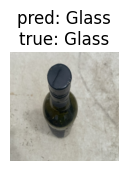

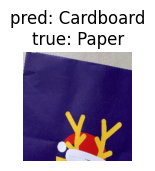

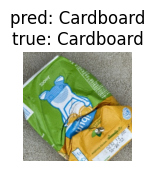

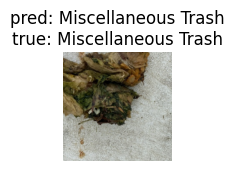

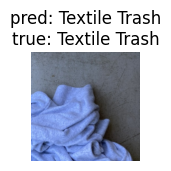

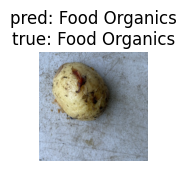

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Function to visualize model predictions
def visualize_model_predictions(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

# Visualize predictions on validation data
visualize_model_predictions(model, val_loader, class_names, num_images=6)
